# Introduction

This paper implements a variant LeNet-5 model outlined in:

Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, [https://doi.org/10.1109/5.726791](http://).

The variations are to "modernize" implementations a bit.

In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import v2

In [2]:
# Gettting the data set
traintransforms = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(),
    v2.RandomCrop(32, 4),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
])
trainset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=traintransforms
)
trainloader = DataLoader(
    trainset,
    batch_size=32,
    shuffle=True
)

testtransforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
])
testset = datasets.CIFAR10(
    root='./data', 
    train=False,    
    download=True,
    transform=testtransforms
)
testloader = DataLoader(
    testset,
    batch_size=32
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Setup device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.net(x)

net = LeNet5()
net.to(device)
print(net)

LeNet5(
  (net): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


Epoch: 40 / 40.   Loss: 2.920%

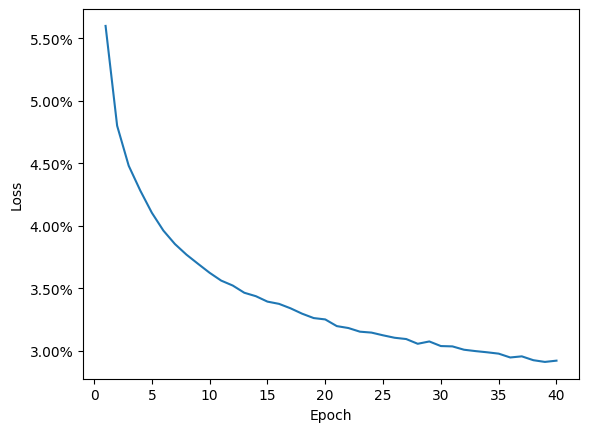

In [5]:
def train():
    epochs = 40
    learning_rate = 0.001
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    x = np.arange(1, epochs + 1)
    y = np.zeros(epochs)

    print("Epoch:  0 / 40.   Loss: N/A", end="\r")
    for epoch in range(epochs):
        epoch_loss = 0.0

        for ip, ground_truth in trainloader:
            ip = ip.to(device)
            ground_truth = ground_truth.to(device)
            optimizer.zero_grad()
            op = net(ip)
            loss = nn.CrossEntropyLoss()(op, ground_truth)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        y[epoch] = epoch_loss / len(trainloader.dataset)
        print(f"Epoch: {epoch + 1:2} / 40.   Loss: {y[epoch]:.3%}", end = "\r")

    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    plt.show()

train()

In [6]:
def test():
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            im = im.to(device)
            ground_truth = ground_truth.to(device)
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()
    accuracy = success / counter
    print(f"LeNet accuracy on {counter} images from test dataset: {accuracy:.3%}")

test()

LeNet accuracy on 10000 images from test dataset: 67.890%
